In [1]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [6]:

# Load the Pubmed dataset
dataset = Planetoid(root='data/Planetoid', name='Pubmed', transform=NormalizeFeatures())

Processing...
Done!


In [8]:
dataset.data

/Users/ashish.kumarsinha/Documents/workspace/misc/.venv/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

In [10]:
# Access the data
data = dataset[0]  # Pubmed has only one graph in the dataset

# Print basic information about the dataset and graph
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'\nGraph information:')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Pubmed()
Number of graphs: 1
Number of features: 500
Number of classes: 3

Graph information:
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [13]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

In [15]:
import random

/var/folders/3j/w1l38cfj2x1_r71n0krg1xnm0000gp/T/ipykernel_84392/2516998985.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(G.nodes, num_sampled_nodes)


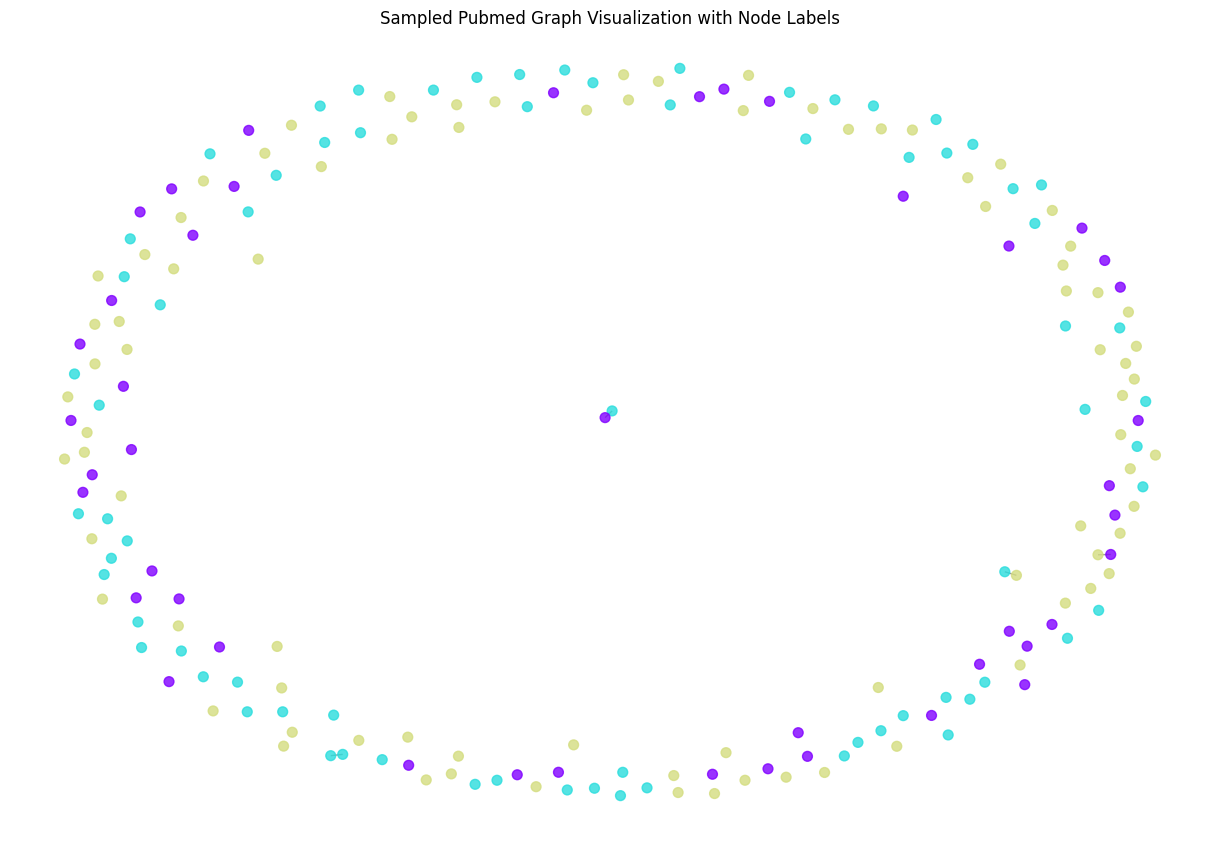

In [16]:
# Convert the graph to a NetworkX graph for visualization
G = to_networkx(data, to_undirected=True, remove_self_loops=True)

# Sample a subset of nodes (e.g., 200 nodes)
num_sampled_nodes = 200
sampled_nodes = random.sample(G.nodes, num_sampled_nodes)

# Extract the subgraph induced by the sampled nodes
subgraph = G.subgraph(sampled_nodes)

# Get node colors based on labels for the sampled nodes
labels = data.y.numpy()
node_labels_sampled = [labels[node] for node in sampled_nodes]
unique_labels_sampled = set(node_labels_sampled)
color_map_sampled = {label: plt.cm.rainbow(i / len(unique_labels_sampled)) for i, label in enumerate(unique_labels_sampled)}
node_colors_sampled = [color_map_sampled[label] for label in node_labels_sampled]

# Plot the sampled subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Force-directed layout for better visualization
nx.draw(subgraph, pos, node_color=node_colors_sampled, with_labels=False, node_size=50, alpha=0.8, edge_color="gray")
plt.title("Sampled Pubmed Graph Visualization with Node Labels")
plt.show()

In [32]:
import torch
import torch.nn.functional as F
from torch.nn import Dropout
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout = Dropout()

    def forward(self, x, edge_index):
        # First layer + activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        # Second layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the model using the number of input features, hidden layer size, and number of classes
model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=dataset.num_classes)


In [33]:
# Use the already loaded data
data = dataset[0]

# Move data to the same device as the model (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

In [34]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training function with validation
def train_with_val():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    return val_loss.item()


def test():
    model.eval()
    out = model(data.x, data.edge_index)  # Forward pass
    # Get predictions and compute accuracy for train, val, and test masks
    pred = out.argmax(dim=1)  # Use the class with the highest score as the predicted class
    accuracy = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        accuracy.append(correct / mask.sum().item())
    return accuracy

Epoch: 000, Loss: 0.1376, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.7950
Epoch: 000, Train Loss: 0.1376, Val Loss: 0.5521
Epoch: 010, Loss: 0.1322, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.7930
Epoch: 010, Train Loss: 0.1322, Val Loss: 0.5564
Epoch: 020, Loss: 0.1274, Train Acc: 1.0000, Val Acc: 0.7880, Test Acc: 0.7900
Epoch: 020, Train Loss: 0.1274, Val Loss: 0.5604
Epoch: 030, Loss: 0.1452, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7880
Epoch: 030, Train Loss: 0.1452, Val Loss: 0.5550
Epoch: 040, Loss: 0.1211, Train Acc: 1.0000, Val Acc: 0.7880, Test Acc: 0.7870
Epoch: 040, Train Loss: 0.1211, Val Loss: 0.5534
Epoch: 050, Loss: 0.1126, Train Acc: 1.0000, Val Acc: 0.7880, Test Acc: 0.7950
Epoch: 050, Train Loss: 0.1126, Val Loss: 0.5533
Epoch: 060, Loss: 0.1136, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.7970
Epoch: 060, Train Loss: 0.1136, Val Loss: 0.5498
Epoch: 070, Loss: 0.1516, Train Acc: 1.0000, Val Acc: 0.7880, Test Acc: 0.7960
Epoch: 070, Train Loss: 0

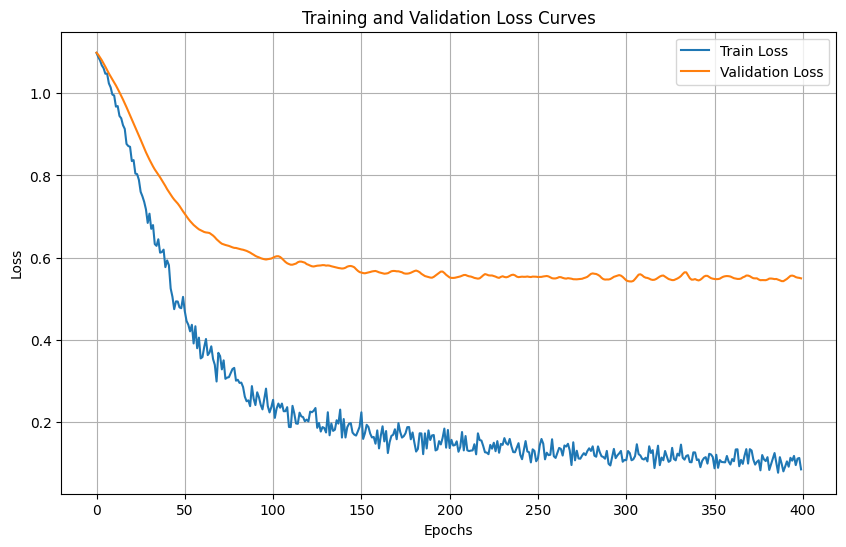

In [36]:
# Training loop with loss recording
epochs = 200
metrics = {'train_loss' : [],
           'train_acc' : [],
           'val_loss' : [],
           'val_acc' : [],
           'test_acc' : []}
for epoch in range(epochs):
    train_loss = train_with_val()
    val_loss = validate()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

torch.Size([19717])